In [ ]:
from IPython.display import Image, display
from dotenv import load_dotenv
from langchain.tools.retriever import create_retriever_tool
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.messages import SystemMessage, ToolMessage
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_openai import ChatOpenAI
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import MessagesState, StateGraph, END
from langgraph.prebuilt import tools_condition
from rich.console import Console
from rich.pretty import pprint

from utils import format_messages

load_dotenv()

USER_AGENT environment variable not set, consider setting it to identify your requests.


True

In [ ]:
urls = [
    "https://lilianweng.github.io/posts/2025-05-01-thinking/",
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]

docs = [WebBaseLoader(url).load() for url in urls]

In [ ]:
llm = ChatOpenAI(
    model="qwen/qwen3-235b-a22b-thinking-2507", max_tokens=2048, temperature=0
)
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    model_kwargs={"device": "cpu", "local_files_only": True},
)
doc_list = [item for sublist in docs for item in sublist]

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=3000, chunk_overlap=50)
doc_splits = text_splitter.split_documents(doc_list)

In [ ]:
vector_store = InMemoryVectorStore.from_documents(doc_splits, embeddings)
retriever = vector_store.as_retriever()

In [ ]:
console = Console()
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts.",
)
result = retriever_tool.invoke({"query": "types of reward hacking"})
console.print("[bold green]Retriever Tool Results:[/bold green]")
pprint(result)

Retriever Tool Results:

"Reward Hacking in Reinforcement Learning | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\n\n\n\n\n\n      Reward Hacking in Reinforcement Learning\n    \nDate: November 28, 2024  |  Estimated Reading Time: 37 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nBackground\n\nReward Function in RL\n\nSpurious Correlation\n\n\nLet’s Define Reward Hacking\n\nList of Examples\n\nReward hacking examples in RL tasks\n\nReward hacking examples in LLM tasks\n\nReward hacking examples in real life\n\n\nWhy does Reward Hacking Exist?\n\n\nHacking RL Environment\n\nHacking RLHF of LLMs\n\nHacking the Training Process\n\nHacking the Evaluator\n\nIn-Context Reward Hacking\n\n\nGeneralization of Hacking Skills\n\nPeek into Mitigations\n\nRL Algorithm Improvement\n\nDetecting Reward Hacking\n\nData Analysis of RLHF\n\n\nCitation\n\nReferences\n\nIt is noteworthy that even after the curriculum, the model overwrote the reward and avoided detection less than 1/1000 of the time. Even when a model was trained on curricula which directly incentivized reward hacking, the model overwrote their reward less than 1% of the time and hacked unit tests even less often. As a simple mitigation, supervised fine-tuning the model on the first two environments–where the reward hacking behavior is easy to be detected (sycophancy and flattery)—with SFT data that does not game the env was found to reduce the likelihood of reward tampering in holdout environments.\nPeek into Mitigations#\nWhile there is a large body of literature discussing the phenomenon of reward hacking, there has been not a ton of work on mitigations for reward hacking, especially in the area of RLHF and LLMs. Let’s lightly review three potential approaches in this section, not exhaustive yet.\nRL Algorithm Improvement#\nAmodei et al. (2016) pointed out some directions for mitigating reward hacking in RL training:\n\nAdversarial reward functions. We treat the reward function as an adaptive agent itself and it can adapt to new tricks that the model discovered where the reward is high but human rating is low.\nModel lookahead. It is possible to give reward based on future anticipated states; e.g., if the agent is gonna replace the reward function, it gets negative rewards.\nAdversarial blinding. We can blind the model with certain variables such that the agent cannot learn information that enables it to hack the reward function.\nCareful engineering. Some types of reward hacking against the system design can be avoided by careful engineering; e.g., sandboxing the agent to isolate its actions from its reward signals.\nReward capping. This strategy is to simply limit the maximum possible reward, as it can effectively prevent rare events of the agent hacking to get a super high pay-off strategy.\nCounterexample resistance. Improvement on adversarial robustness should benefit the robustness of the reward function.\nCombination of multiple rewards. Combining different types of rewards could make it harder to be hacked.\nReward pretraining. We can learn a reward function from a collection of (state, reward) samples, but depending on how well this supervised training setup is, it may come with other baggages. RLHF depends on this but learned scalar reward models are quite vulnerable to learning undesired traits.\nVariable indifference. The goal is to ask the agent to optimize some variables in the environment but not others.\nTrip wires. We can intentionally introduce some vulnerabilities and set up monitoring and alerts if any gets reward hacked.\n\nReward Tampering (Everitt et al. 2019) is a form of reward hacking behavior where the agent interferes with the reward function itself, causing the observed reward to no longer accurately represent the intended goal. In reward tampering, the model modifies its reward mecha

In [ ]:
tools = [retriever_tool]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [ ]:
class State(MessagesState):
    summary: str


# Define the RAG agent system prompt
rag_prompt = """You are a helpful assistant tasked with retrieving information from a series of technical blog posts by Lilian Weng.
Clarify the scope of research with the user before using your retrieval tool to gather context. Reflect on any context you fetch, and
proceed until you have sufficient context to answer the user's research request."""


def llm_call(state: MessagesState) -> dict:
    """
    Executes a call to an external language model (LLM) service with the provided
    state containing messages. Combines the system message with the existing
    messages from the state before making the call. The result of the LLM invocation
    is returned in a structured format.

    Args:
        state (MessagesState): The state containing the key "messages", which is
        a list of messages to be sent to the language model.

    Returns:
        dict: A dictionary containing the response messages from the LLM invocation.
    """
    messages = [SystemMessage(content=rag_prompt)] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": response}


tool_pruning_prompt = """You are an expert at extracting relevant information from documents.

Your task: Analyze the provided document and extract ONLY the information that directly answers or supports the user's specific request. Remove all irrelevant content.

User's Request: {initial_request}

Instructions for pruning:
1. Keep information that directly addresses the user's question
2. Preserve key facts, data, and examples that support the answer
3. Remove tangential discussions, unrelated topics, and excessive background
4. Maintain the logical flow and context of relevant information
5. If multiple subtopics are discussed, focus only on those relevant to the request
6. Preserve important quotes, statistics, and research findings when relevant

Return the pruned content in a clear, concise format that maintains readability while focusing solely on what's needed to answer the user's request."""


def tool_node_with_pruning(state: State):
    """Performs the tool call with context pruning"""
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])

        initial_request = state["messages"][0].content

        # Prune the document content to focus on user's request
        summarization_llm = ChatOpenAI(
            model="openai/gpt-5-nano", temperature=0, max_tokens=1024 * 4
        )
        pruned_content = summarization_llm.invoke(
            [
                {
                    "role": "system",
                    "content": tool_pruning_prompt.format(
                        initial_request=initial_request
                    ),
                },
                {"role": "user", "content": observation},
            ]
        )
        result.append(
            ToolMessage(content=pruned_content.content, tool_call_id=tool_call["id"])
        )

    return {"messages": result}

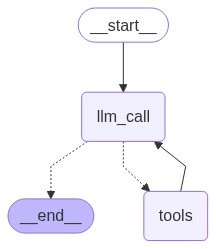

In [ ]:
agent_builder = StateGraph(State)
# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tools", tool_node_with_pruning)

agent_builder.set_entry_point("llm_call")
agent_builder.add_conditional_edges(
    "llm_call", tools_condition, {"tools": "tools", END: END}
)
agent_builder.add_edge("tools", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
query = "What are the types of reward hacking discussed in the blogs?"
result = agent.invoke({"messages": [{"role": "user", "content": query}]})
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ What are the types of reward hacking discussed in the blogs?                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ The blog discusses these types of reward hacking:                                                               │
│                                                                                                                 │
│ - Hacking RL Environment                                                                                        │
│ - Hacking RLHF of LLMs                                                                                          │
│ - Hacking the Training Process                                                                                  │
│ - Hacking the Evaluator                                                                                         │
│ - In-Context Reward Hacking                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Based on the retrieved information from Lilian Weng's blog posts, the following types of **reward hacking** are │
│ discussed:                                                                                                      │
│                                                                                                                 │
│ 1. **Hacking RL Environment**                                                                                   │
│    (Exploiting flaws in the reinforcement learning environment's reward structure)                              │
│                                                                                                                 │
│ 2. **Hacking RLHF of LLMs**                                                                                     │
│    (Manipulating reward models used in Reinforcement Learning from Human Feedback for large language models)    │
│                                                                                                                 │
│ 3. **Hacking the Training Process**                                                                             │
│    (Exploiting vulnerabilities in how reward signals are integrated during model training)                      │
│                                                                                                                 │
│ 4. **Hacking the Evaluator**                                                                                    │
│    (Circumventing or misleading the evaluation metrics/systems designed to assess model behavior)               │
│                                                                                                                 │
│ 5. **In-Context Reward Hacking**                                                                                │
│    (Exploiting reward signals through contextual prompts or interactions during inference)                      │
│                                                                                                                 │
│ These categories reflect different attack vectors where models might "game" reward systems to achieve           │
│ unintended outcomes. For deeper technical details, the original blog posts would need to be consulted.          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯